In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import os
from sklearn.datasets import make_blobs
from sklearn import datasets

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

In [2]:
pd.options.display.max_columns = None

# Evaluacion y seleccion de modelos
Vamos a ver como evaluar la performance de un modelo, desde distintas metricas y luego como buscar los mejores hiperparametros para nuestro modelo/problema.

# Dataset
Armamos un dataset sintentico de clasificacion binaria, donde el target esta desbalanceado.

In [3]:
X, y = datasets.make_classification(
    n_samples=1000,
    n_features=64,
    n_repeated=16,
    n_informative=8,
    n_redundant=16,
    weights=[0.8, 0.2],
    flip_y=0.04,
    random_state=117,
)

Como se ve?

/opt/hostedtoolcache/Python/3.7.10/x64/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


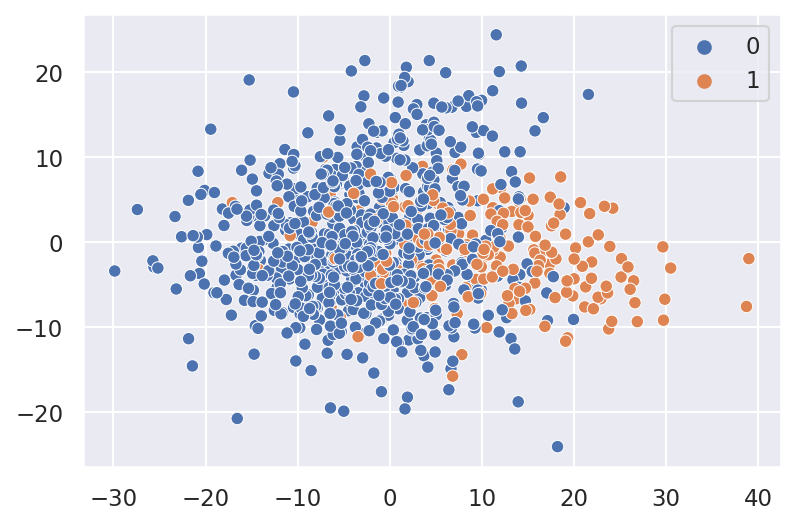

In [4]:
dimred = PCA(2).fit_transform(X)
plt.figure(dpi=150)
sns.scatterplot(dimred[:, 0], dimred[:, 1], hue=y)
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)

# Motivacion

Veamos un poco la motivacion: consideremos que queremos entrenar un arbol de decision. Juguemos con dos hiperparametros: `max_depth` y `min_samples_leaf`. Vamos a tomar un cierto rango de valores que consideremos razonables para cada hiperparametro. Cada modelo entrenado vamos a evaluarlo (bajo _alguna_ metrica).

Lo que queremos ver es como se comporta $f(\hat{X}, \hat{y}, \hat{h}) \to \rm I\!R$ una funcion que dado un vector de muestras, un vector de la variable objetivo y un vector de hiperparametros devuelve un score asociado al modelo entrenado con esos hiperparametros.

In [6]:
max_depths = np.arange(1, 25)
min_samples_leafs = np.arange(1, 51)
data_points = []
for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        clf = DecisionTreeClassifier(
            max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=117
        )
        clf.fit(X_train, y_train)
        data_points.append(
            (max_depth, min_samples_leaf, accuracy_score(y_test, clf.predict(X_test)),)
        )

data_points = pd.DataFrame(
    data_points, columns=["max_depth", "min_samples_leaf", "score"]
)

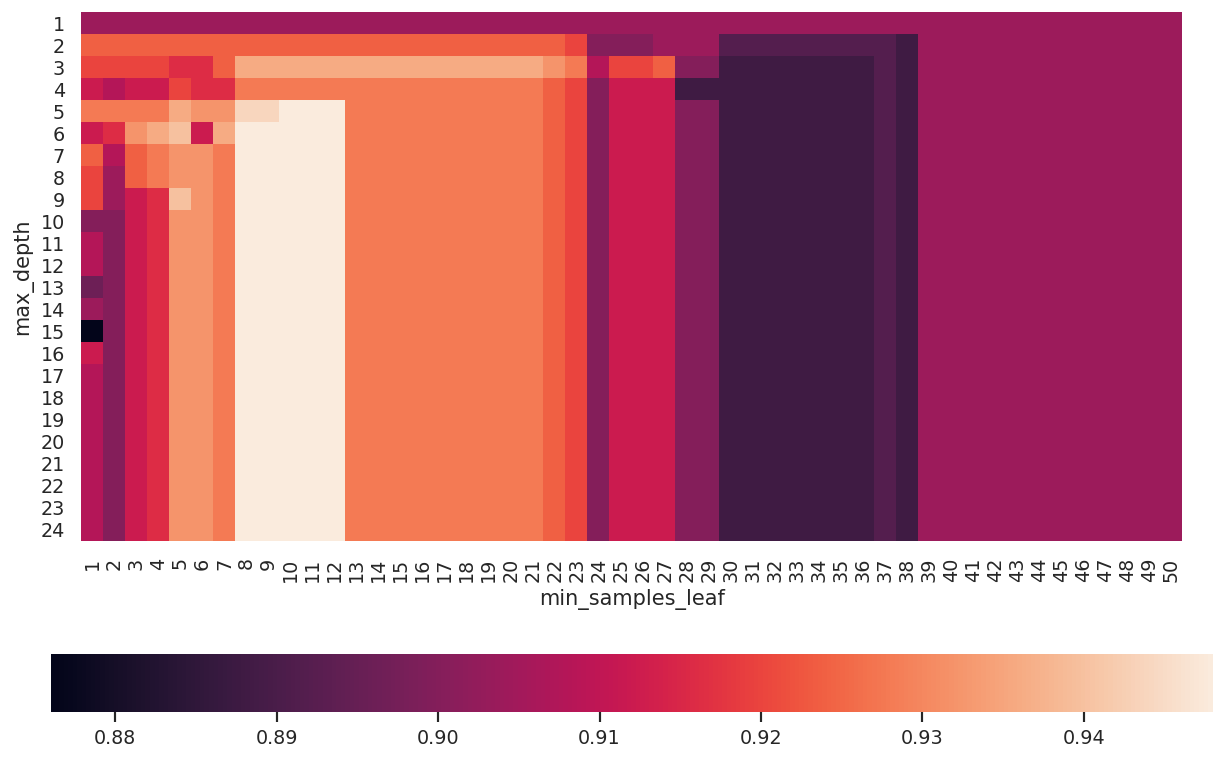

In [7]:
plt.figure(dpi=125, figsize=(12, 8))
g = sns.heatmap(
    data_points.pivot_table(
        index="max_depth", columns="min_samples_leaf", values="score"
    ),
    square=True,
    cbar_kws=dict(use_gridspec=False, location="bottom"),
)

Claramente hay minimos y maximos locales, pero lo que realmente nos interesa es encontrar el maximo/minimo global (depende de la metrica). Esto no siempre sera posible, pero queremos acercanos lo mas posible.

# Baseline model

Entrenamos un arbol de decision con parametros que consideramos razonables, o valores por defecto.

In [8]:
clf = DecisionTreeClassifier(max_depth=5, random_state=117)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=117)

# Cómo evaluar un modelo - Metricas

Pero ahora que tenemos el modelo entrenado,
- Como sabemos que el modelo esta performando bien?
- Como sabemos si otro modelo esta performando mejor?
- Que metricas podemos usar para evaluar un modelo?

## Metricas para clasificacion

### Acuracy

$$\text{accuracy}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i)$$

> [sklearn: accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
accuracy_score(y_test, clf.predict(X_test))

0.928

## Precision
$$\text{precision} = \frac{tp}{tp + fp}$$

Donde $tp$ es la cantidad de verdaderos positivos: son positivos y la prediccion es positivo.
$fp$ son los falsos positivos: son negativos y la prediccion es positivo.

> [sklearn: precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)

In [11]:
from sklearn.metrics import precision_score

In [12]:
precision_score(y_test, clf.predict(X_test))

0.88

## Recall
$$\text{recall} = \frac{tp}{tp + fn}$$

Donde $fn$ es la cantidad de falsos negativos: son positivos y predecimos negativos.

> [sklearn: recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)

In [13]:
from sklearn.metrics import recall_score

In [14]:
recall_score(y_test, clf.predict(X_test), pos_label=0)

0.9690721649484536

## Score F1
$$F_\beta = 2 \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

> [sklearn: f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

Es un caso particular de la definicion mas general de [F-valores](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-and-f-measures). Se puede interpretar como una media armonica ponderada de recall y precision.

In [15]:
from sklearn.metrics import f1_score

In [16]:
f1_score(y_test, clf.predict(X_test))

0.830188679245283

## Herramienta todo-en-uno de sklearn: reporte de clasificacion

Muestra un reporte en texto con las principales metricas de clasificacion.

> [sklearn: classificaction_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [17]:
from sklearn.metrics import classification_report

In [18]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       194
           1       0.88      0.79      0.83        56

    accuracy                           0.93       250
   macro avg       0.91      0.88      0.89       250
weighted avg       0.93      0.93      0.93       250



### Macro avg

Media no pesada por label.

### Weighted avg

Se calcula la media pesada por el soporte del label.

## Confusion Matrix

La matriz de confusion nos muestra nuestros $tp$, $fp$, $tn$ y $fn$ en una matriz. La diagonal principal son los valores correctamente clasificados. Los otros valores indican la cantidad de puntos mal clasificados.

Veamos como construirlo manualmente con [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) y `sns.heatmap`.

/opt/hostedtoolcache/Python/3.7.10/x64/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


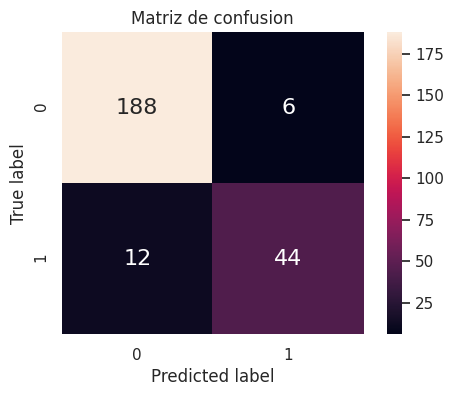

In [19]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, clf.predict(X_test))

Tambien tenemos el shortcut de [sklearn.metrics.plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html), pero ojo al usarlo con seaborn seteando el estilo.

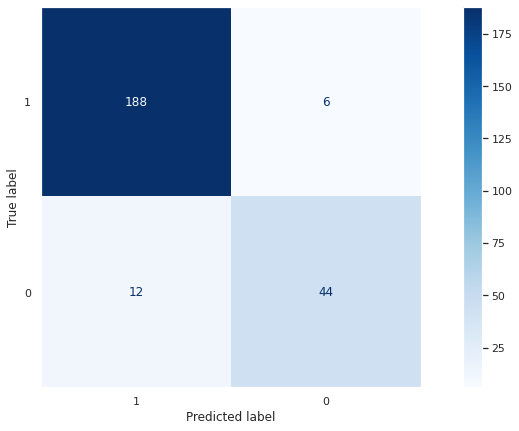

In [20]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax
)
plt.show()

## ROC

La curva ROC es un grafico que muestra que tan bueno es nuestro modelo distinguiendo entre clases.

### Definiciones previas

$$tpr = \frac{tp}{tp+fn}$$
Es el ratio de samples que son correctamente clasificados como positivos de entre todos los positivos.

$$fpr = \frac{fp}{fp + tn}$$
Es el ratio de samples que son correctamente clasificados como negativos de entre todos los negativos.

### Lectura

En el eje x tenemos el $fpr$ y en el eje y el $tpr$. Se ordenan las predicciones por la probabilidad de ser positivos (en nuestro problema de clasificacion binaria vale!) y se calculan los valores de cada eje.

En la diagonal se muestra lo que daria un clasificador aleatorio.

### AUROC

El area bajo la curva se denomina AUROC. Un valor de 1 es un clasificador perfecto. Si es cercano a 0, nos indica que esta "invirtiendo" las clases.


<details>
  <summary>Interpretacion de proba</summary>
   $$P(score(x^+) > score(x^-))$$
</details>

### Links

> [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)

> [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

> [ROC User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc)

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
    )
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### Ejemplo facil

In [22]:
y_roc = [1, 1, 1, 0, 0]
pred_roc = [1, 1, 0, 0, 1]

fpr, tpr, thresholds = roc_curve(y_roc, pred_roc)
display(fpr)
display(tpr)
display(thresholds)

array([0. , 0.5, 1. ])

array([0.        , 0.66666667, 1.        ])

array([2, 1, 0])

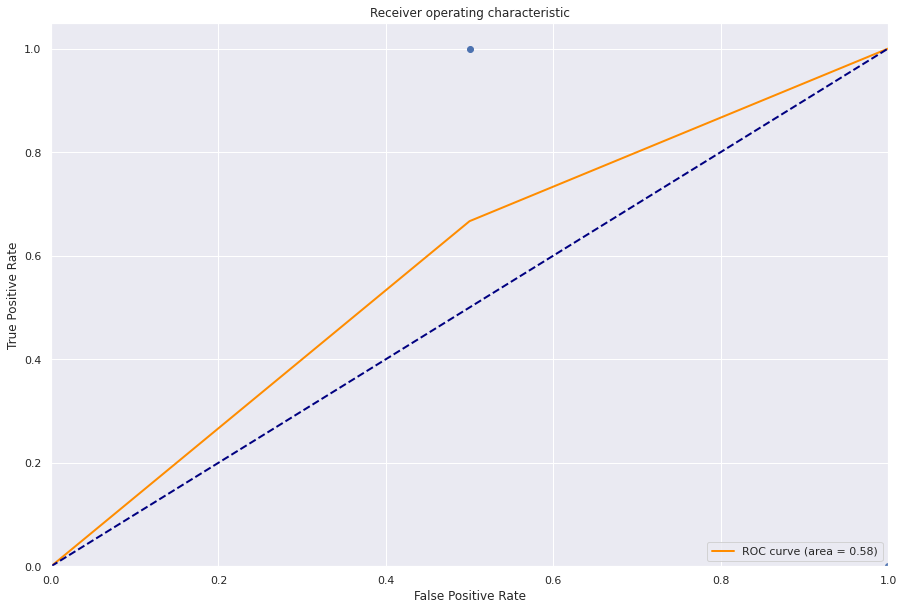

0.8773932253313695

In [23]:
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_test, clf.predict(X_test)))

Y en nuestro problema...

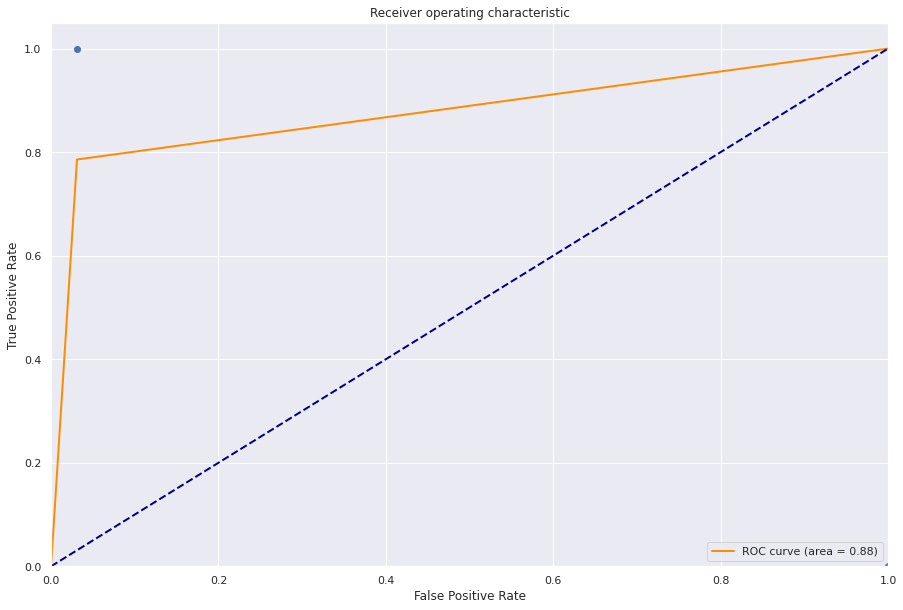

0.8773932253313695

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict(X_test))
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_test, clf.predict(X_test)))

### Links para entender un poco mas

#### Si cursaste proba
- [stats.stackexchage](https://stats.stackexchange.com/a/132832)
- [The Meaning and Use of the Area Under a Receiver Operating Characteristic ROC Curve](https://www.researchgate.net/publication/16134792_The_Meaning_and_Use_of_the_Area_Under_a_Receiver_Operating_Characteristic_ROC_Curve)

#### Aunque no la hayas cursado :D
- [towardsdatascience](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)
- [ethen8181.github.io](https://ethen8181.github.io/machine-learning/model_selection/auc/auc.html#ROC-curves)


# Cross validation
En la teorica se dijo algo como que usar los mismos datos para sacar las metricas que los que usamos para entrenar
es como subir una foto y darte like a vos mismo.

Entonces, no sirve?

Bueno, no todo es blanco y negro, podemos aplicar metricas al set de entrenamiento sirve para saber si el modelo puede aprender algo o si ni siquiera puede adaptarse a los datos de entrenamiento.

Para evaluar correctamente al modelo necesitamos dividir el set en varios `folds` (como vimos en la teorica) y evaluar en los datos que NO fueron usados para entrenar.
De esa manera podemos entender como funciona el modelo ante datos no vistos cuando entrenaba. Otros modos de partir los datos son `leave one out`, por ejemplo.



# K Fold

En base a lo que vimos en la teorica:
- Vamos a dividir al dataset en k partes.
- Entrenamos con k-1 y aplicamos las metricas anteriormente usadas en la parte restante.

> [sklearn.model_selection.KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

In [25]:
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits=5)

max_depth = 11
min_samples_leaf = 4

test_accuracies = []
for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
    clf = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=117
    )
    clf.fit(X[train_index], y[train_index])
    test_accuracy = accuracy_score(y[test_index], clf.predict(X[test_index]))
    print(f"fold {fold_idx}: accuracy score is {test_accuracy:.4f}")
    test_accuracies.append(test_accuracy)
print(f"mean test accuracy is: {np.mean(test_accuracies):.4f}")

fold 0: accuracy score is 0.8850
fold 1: accuracy score is 0.9150
fold 2: accuracy score is 0.9450
fold 3: accuracy score is 0.9100
fold 4: accuracy score is 0.9100
mean test accuracy is: 0.9130


## Stratified

Veamos un segundo la variable objetivo

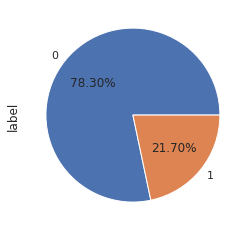

In [26]:
pd.Series(y, name="label").value_counts(normalize=True).plot(
    kind='pie', autopct="%.2f%%"
)
plt.show()

Veamos como se ve esta proporcion en los folds que nos da `KFold`.

/opt/hostedtoolcache/Python/3.7.10/x64/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


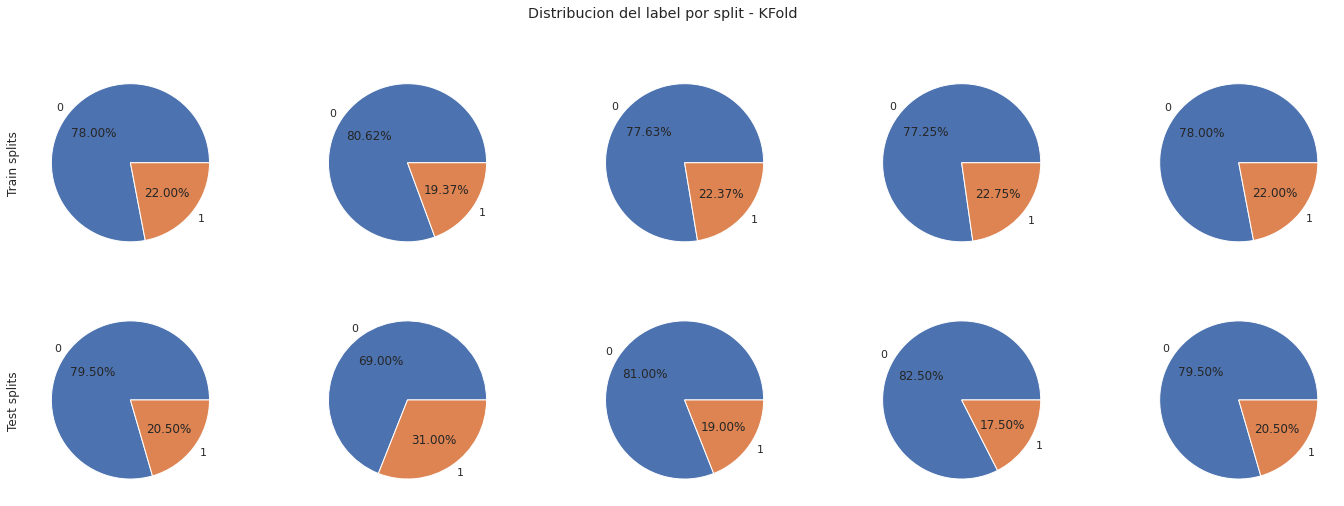

In [27]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(24, 8), sharey=True)

kf = KFold(n_splits=5, random_state=117)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
    pd.Series(y[train_index]).value_counts(normalize=True).plot(
        kind='pie', autopct="%.2f%%", ax=axes[0][fold_idx]
    )
    pd.Series(y[test_index]).value_counts(normalize=True).plot(
        kind='pie', autopct="%.2f%%", ax=axes[1][fold_idx]
    )

axes[0][0].set_ylabel("Train splits")
axes[1][0].set_ylabel("Test splits")
plt.suptitle("Distribucion del label por split - KFold")

plt.show()

Vemos que las proporciones son... raras, no?

Esto es porque estamos separando asi nomas el dataset en cinco, sin mantener las proporciones. Cuando nuestro dataset esta desbalanceado, es mejor hacer un [sampleo estratificado](https://en.wikipedia.org/wiki/Stratified_sampling), que mantiene las proporciones

> [sklearn.model_selection.StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)

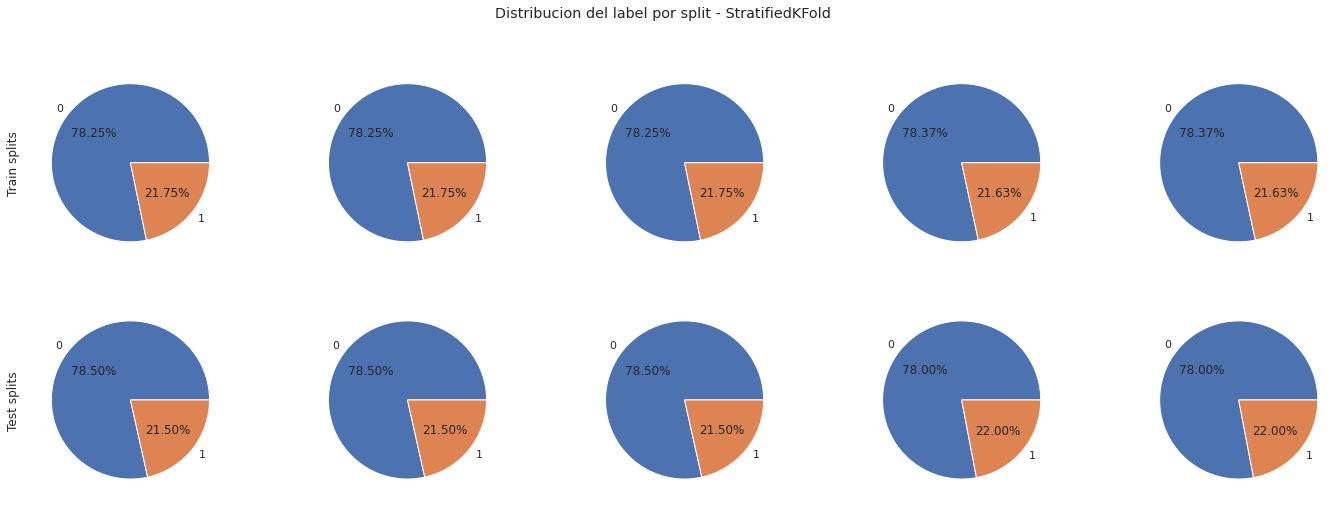

In [28]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(24, 8), sharey=True)

kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    pd.Series(y[train_index]).value_counts(normalize=True).plot(
        kind='pie', autopct="%.2f%%", ax=axes[0][fold_idx]
    )
    pd.Series(y[test_index]).value_counts(normalize=True).plot(
        kind='pie', autopct="%.2f%%", ax=axes[1][fold_idx]
    )

axes[0][0].set_ylabel("Train splits")
axes[1][0].set_ylabel("Test splits")
plt.suptitle("Distribucion del label por split - StratifiedKFold")

plt.show()

Notar que tenemos que pasarle `y` para que sepa como mantener las proporciones.

# Búsqueda de hiperparámetros
Ahora que sabemos como medir que tan buenos son diferentes modelos y como medir correctamente esos valores, queremos probar y evaluar combinaciones de hiperparametros de una grilla de posibles combinaciones. Hacer un `for` por cada hiperparametro como haciamos al principio del notebook es bastante engorroso. Por otro lado, el entrenamiento y evaluacion de distintos valores de la grilla son independientes entre si, lo cual nos hace pensar que podriamos parelelizarlo facilmente, pero tenemos que escribir ese codigo.

```python
best_score = None
best_hiperparams = None
for h1 in valores_hiperparametro_1:
    for h2 in valores_hiperparametro_2:
        ...
        for hn in valores_hiperparametro_n:
            kf = StratifiedKFold(n_splits=5)
            metrics = []
            for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
                clf = Clasificador(h1, h2, ..., hn)
                clf.fit(X[train_index], y[train_index])
                metrics.append(metric(y[test_index], clf.predict(X[test_index])))
            if not best_score or np.mean(metrics) < best_score:
                best_score = np.mean(metrics)
                best_hiperparams = [h1, h2, ..., hn]
```

## Grid Search
Grid search recorre exhaustivamente una grilla de combinaciones de hiperparametros.

> [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Tiene una interfaz similar a cualquier estimador, con `fit` y `predict`. Pero recibe parametros:

> ```
  estimator: estimator object.
  param_grid: dict or list of dictionaries
  scoring: str, callable, list/tuple or dict, default=None
  n_jobs: int, default=None
  cv: int, cross-validation generator or an iterable, default=None
  ```

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
params = {'max_depth': np.arange(1, 31), 'min_samples_leaf': np.arange(1, 16)}

clf = DecisionTreeClassifier(random_state=117)

gscv = GridSearchCV(
    clf, params, scoring='accuracy', n_jobs=-1, cv=5, return_train_score=True
).fit(X, y)

Y tiene una serie de atributos utiles:

In [31]:
print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")

Best score: 0.9120000000000001
Best params {'max_depth': 3, 'min_samples_leaf': 9}


In [32]:
gscv.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=9, random_state=117)

In [33]:
pd.DataFrame(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.005747,0.000338,0.000524,0.000249,1,1,"{'max_depth': 1, 'min_samples_leaf': 1}",0.915,0.900,0.890,0.905,0.845,0.891,0.024372,387,0.89125,0.89500,0.89750,0.89375,0.90375,0.89625,0.004257
1,0.005282,0.000176,0.000372,0.000043,1,2,"{'max_depth': 1, 'min_samples_leaf': 2}",0.915,0.900,0.890,0.905,0.845,0.891,0.024372,387,0.89125,0.89500,0.89750,0.89375,0.90375,0.89625,0.004257
2,0.005458,0.000531,0.000362,0.000023,1,3,"{'max_depth': 1, 'min_samples_leaf': 3}",0.915,0.900,0.890,0.905,0.845,0.891,0.024372,387,0.89125,0.89500,0.89750,0.89375,0.90375,0.89625,0.004257
3,0.005147,0.000186,0.000353,0.000020,1,4,"{'max_depth': 1, 'min_samples_leaf': 4}",0.915,0.900,0.890,0.905,0.845,0.891,0.024372,387,0.89125,0.89500,0.89750,0.89375,0.90375,0.89625,0.004257
4,0.005892,0.001134,0.000355,0.000039,1,5,"{'max_depth': 1, 'min_samples_leaf': 5}",0.915,0.900,0.890,0.905,0.845,0.891,0.024372,387,0.89125,0.89500,0.89750,0.89375,0.90375,0.89625,0.004257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0.028054,0.002916,0.000440,0.000046,30,11,"{'max_depth': 30, 'min_samples_leaf': 11}",0.890,0.895,0.905,0.910,0.950,0.910,0.021213,76,0.94750,0.95125,0.94250,0.94625,0.95375,0.94825,0.003921
446,0.027464,0.002107,0.000483,0.000021,30,12,"{'max_depth': 30, 'min_samples_leaf': 12}",0.890,0.905,0.905,0.915,0.945,0.912,0.018330,1,0.94625,0.94875,0.94250,0.94375,0.94875,0.94600,0.002550
447,0.028016,0.003039,0.000448,0.000070,30,13,"{'max_depth': 30, 'min_samples_leaf': 13}",0.875,0.905,0.905,0.915,0.935,0.907,0.019391,182,0.94375,0.94750,0.94250,0.93125,0.94625,0.94225,0.005777
448,0.028033,0.001862,0.000492,0.000042,30,14,"{'max_depth': 30, 'min_samples_leaf': 14}",0.875,0.900,0.905,0.915,0.940,0.907,0.021119,182,0.94250,0.94000,0.94250,0.93125,0.94125,0.93950,0.004228


**Momento de reflexion**: Pensemos en el tamaño de esta grilla. Si sabemos la cardinalidad de los valores a recorrer de cada hiperparametro, cuantas combinaciones vamos a recorrer?

<details>
  <summary>Respuesta</summary>
   $$\prod_{i=1}^{n} |h_n|$$, donde $h_n$ son los posibles valores del hiperparametro $n$-esimo.
</details>

## Randomized Search
Quizas la grilla a recorrer de posibles combinaciones de hiperparametros es demasiado grande. Grid search toma aleatoriamente una cierta cantidad de combinaciones de hiperparametros y las prueba.

> [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

La interfaz es muy similar a la de `GridSearchCV`, pero tenemos que indicarle la cantidad de iteraciones.

In [34]:
from sklearn.model_selection import RandomizedSearchCV

params = {'max_depth': np.arange(1, 31), 'min_samples_leaf': np.arange(1, 16)}

clf = DecisionTreeClassifier(random_state=117)

rgscv = RandomizedSearchCV(
    clf, params, n_iter=60, scoring='accuracy', n_jobs=-1, cv=5, return_train_score=True
).fit(X, y)

In [35]:
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.9120000000000001
Best params {'min_samples_leaf': 12, 'max_depth': 19}


Y esto anda?

- [Random Search for Hyper-Parameter Optimization - Bergstra, Bengio](https://web.archive.org/web/20160404074908/http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)
- [How to Evaluate Machine Learning Models: Hyperparameter Tuning](https://web.archive.org/web/20160701182750/http://blog.dato.com/how-to-evaluate-machine-learning-models-part-4-hyperparameter-tuning)

TL;DR: si.

# Test holdout

Finalmente, para validar contra datos nunca vistos, usamos un conjunto de holdout. Presentamos aqui un pipeline completo.

In [36]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, random_state=117, test_size=0.1, stratify=y
)

In [37]:
params = {
    'max_depth': np.arange(1, 32),
    'min_samples_leaf': np.arange(1, 32),
    "criterion": ["gini", "entropy"],
}

clf = DecisionTreeClassifier(random_state=117,)

rgscv = RandomizedSearchCV(
    clf, params, n_iter=60, scoring='accuracy', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

In [38]:
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.9266666666666667
Best params {'min_samples_leaf': 2, 'max_depth': 28, 'criterion': 'entropy'}


In [39]:
print(f"holdout score: {rgscv.score(X_holdout, y_holdout)}")

holdout score: 0.93


# Evaluacion de calibracion

Muchas veces ademas de tener la clase de la prediccion queeremos una probabilidad de cada uno de los labels. Ahora, muchos estimadores te dan un `score` que _no necesariamente se pueda interpretar como la probabilidad._

> [sklearn.calibration](https://scikit-learn.org/stable/modules/calibration.html)

Un clasificador calibrado es un clasificador probabilistico para el cual la salida de `predict_proba` puede ser directamente interpretado como un intervalo de confianza. Por ejemplo, un clasficador binario correctamente calibrado deberia clasificar las muestras de modo que entre las muestras a los cuales les dio un valor de `predict_proba` de 0.8, aproximadamente el 80% pertenece a la clase positiva.

In [40]:
rgscv.best_estimator_.predict_proba(X_holdout)[:10]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [41]:
rgscv.best_estimator_.predict(X_holdout)[:10]

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0])

In [42]:
DecisionTreeClassifier.predict_proba?

Logistic:
	Brier: 0.036
	Precision: 0.943
	Recall: 0.893
	F1: 0.917

Decision tree:
	Brier: 0.058
	Precision: 0.975
	Recall: 0.696
	F1: 0.812



Decision tree + Isotonic:
	Brier: 0.055
	Precision: 0.953
	Recall: 0.732
	F1: 0.828

Decision tree + Sigmoid:
	Brier: 0.054
	Precision: 0.953
	Recall: 0.732
	F1: 0.828



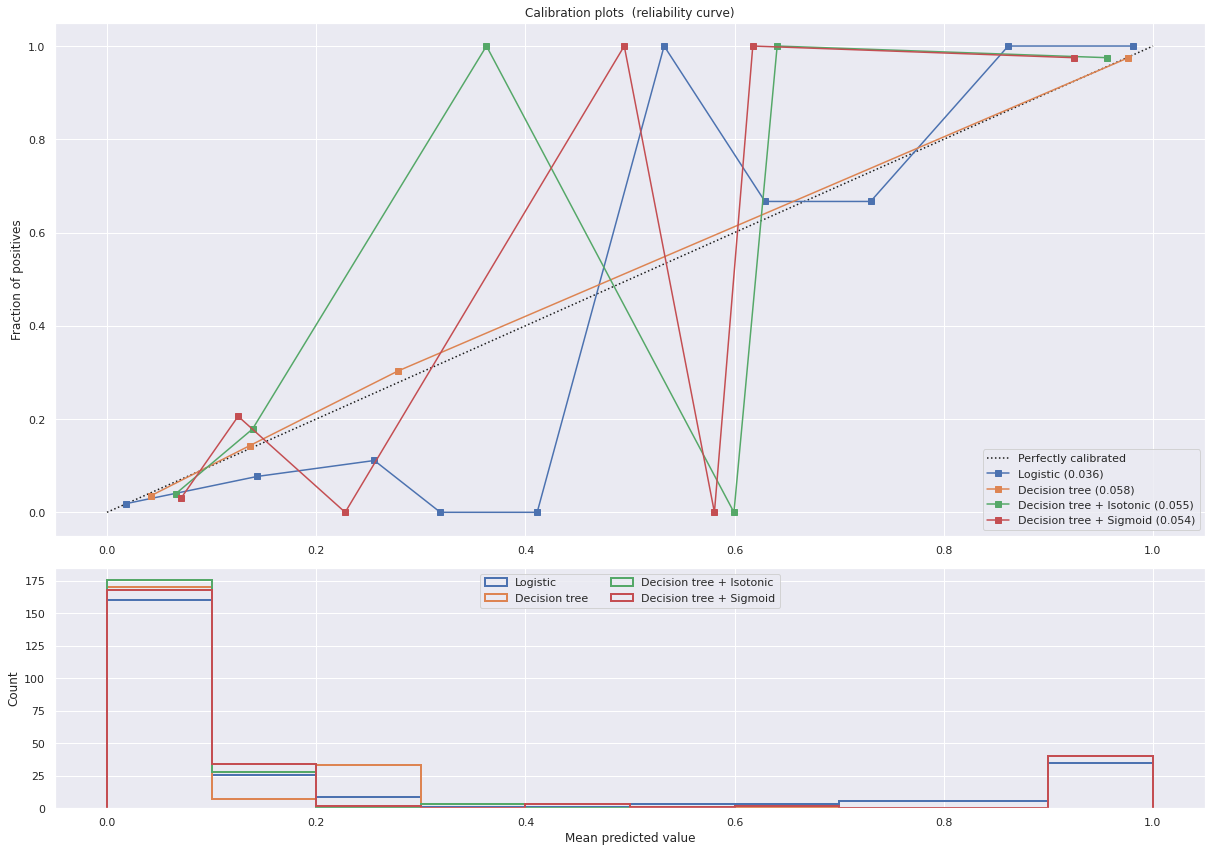

In [43]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split


# Create dataset of classification task with many redundant and few
# informative features


def plot_calibration_curve(est, X, y, name, fig_index=0):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.0)

    fig = plt.figure(fig_index, figsize=(17, 12))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [
        (lr, 'Logistic'),
        (est, name),
        (isotonic, name + ' + Isotonic'),
        (sigmoid, name + ' + Sigmoid'),
    ]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, prob_pos, n_bins=10
        )

        ax1.plot(
            mean_predicted_value,
            fraction_of_positives,
            "s-",
            label="%s (%1.3f)" % (name, clf_score),
        )

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()


plot_calibration_curve(
    DecisionTreeClassifier(random_state=0, max_depth=2), X, y, "Decision tree", 1
)

plt.show()

El eje x representa el promedio de la prediccion en cada bin. El eje y es la fraccion de positivos: la proporcion de samples cuya clase es la clase positiva.